<a href="https://colab.research.google.com/github/KAUZHAL/Quantum_project/blob/main/Quantum_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.0 MB/s eta 0:00:00


In [3]:
!pip install qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 34.5 MB/s eta 0:00:00


In [5]:
from google.colab import files
uploaded = files.upload()

Saving passwords.txt to passwords.txt


In [16]:
# Read passwords from the uploaded file
with open("passwords.txt", "r") as file:
    passwords = [line.strip() for line in file.readlines()]

# Sanity check
if len(passwords) < 32:
    raise ValueError("Need at least 32 passwords in keylogger.txt")

# Select the first 32 passwords
passwords = passwords[:32]

# Choose target password (example: 17th one)
target_index = 16
target_password = passwords[target_index]

print(f"Target password selected: {target_password} (index {target_index})")


Target password selected: Mamtarawat (index 16)


In [17]:
from qiskit import QuantumCircuit

def grover_oracle(target_index, num_qubits):
    oracle = QuantumCircuit(num_qubits)
    binary_str = format(target_index, f'0{num_qubits}b')
    for i, bit in enumerate(reversed(binary_str)):
        if bit == '0':
            oracle.x(i)
    oracle.h(num_qubits - 1)  # Apply H to last qubit
    oracle.mcx(list(range(num_qubits - 1)), num_qubits - 1)  # Multi-controlled X
    oracle.h(num_qubits - 1)
    for i, bit in enumerate(reversed(binary_str)):
        if bit == '0':
            oracle.x(i)
    return oracle

In [18]:
def diffusion_operator(num_qubits):
    diffuser = QuantumCircuit(num_qubits)
    diffuser.h(range(num_qubits))
    diffuser.x(range(num_qubits))
    diffuser.h(num_qubits - 1)
    diffuser.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diffuser.h(num_qubits - 1)
    diffuser.x(range(num_qubits))
    diffuser.h(range(num_qubits))
    return diffuser

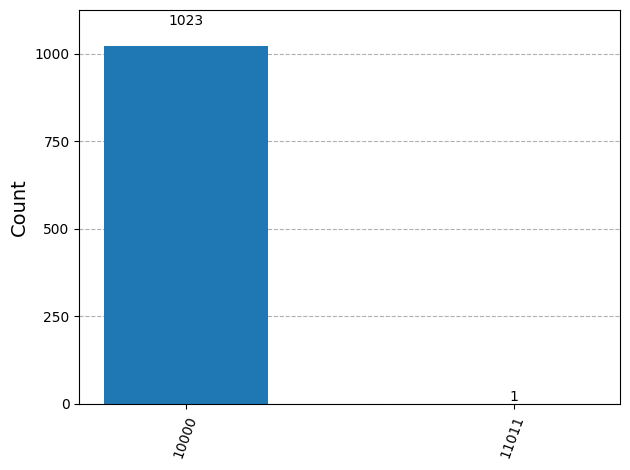

In [19]:
from qiskit_aer import AerSimulator
from qiskit import transpile

num_qubits = 5
oracle = grover_oracle(target_index, num_qubits)
diffuser = diffusion_operator(num_qubits)

grover_circuit = QuantumCircuit(num_qubits, num_qubits)

# Initialize superposition
grover_circuit.h(range(num_qubits))

# Number of Grover iterations ~ π/4 * sqrt(N)
import math
iterations = int(math.pi / 4 * math.sqrt(2 ** num_qubits))

# Apply Grover iterations
for _ in range(iterations):
    grover_circuit.compose(oracle, inplace=True)
    grover_circuit.compose(diffuser, inplace=True)

# Measure
grover_circuit.measure(range(num_qubits), range(num_qubits))

# Simulate
sim = AerSimulator()
compiled_circuit = transpile(grover_circuit, sim)
result = sim.run(compiled_circuit).result()
counts = result.get_counts()

from qiskit.visualization import plot_histogram
plot_histogram(counts)